In [1]:
# 학습 완료한 파일 연동을 위한 drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 학습 완료한 RetinaNet 압축해제
!unzip "/content/drive/MyDrive/project/lecture_mosaic_project_data.zip" -d "/content"

Archive:  /content/drive/MyDrive/project/lecture_mosaic_project_data.zip
   creating: /content/lecture_mosaic_project_data/dataset/
  inflating: /content/lecture_mosaic_project_data/dataset/bts.jpg  
  inflating: /content/lecture_mosaic_project_data/dataset/radio.mp4  
  inflating: /content/lecture_mosaic_project_data/dataset/radio_frame.PNG  
  inflating: /content/lecture_mosaic_project_data/dataset/radio_frame2.PNG  
   creating: /content/lecture_mosaic_project_data/facenet/
  inflating: /content/lecture_mosaic_project_data/facenet/facenet_keras.h5  
   creating: /content/lecture_mosaic_project_data/retinaface/
  inflating: /content/lecture_mosaic_project_data/retinaface/saved_model.pb  
   creating: /content/lecture_mosaic_project_data/retinaface/variables/
  inflating: /content/lecture_mosaic_project_data/retinaface/variables/variables.data-00000-of-00001  
  inflating: /content/lecture_mosaic_project_data/retinaface/variables/variables.index  


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

import numpy as np
from numpy import dot
from numpy.linalg import norm

import os
import sys
import cv2
from google.colab.patches import cv2_imshow
import timeit

from matplotlib import pyplot as plt
from matplotlib import patches
from PIL import Image
from IPython.display import clear_output

1. faceNet model, rentinaNet model load

In [10]:
facenet_model = load_model('/content/lecture_mosaic_project_data/facenet/facenet_keras.h5')

In [11]:
retina = load_model('/content/lecture_mosaic_project_data/retinaface')

2. retina 모델이 정상적으로 load 되어 있는지 확인, bts.jpg 파일 이용

In [248]:
# 이미지 파일을 load, 모델에서 사용할 수 있는 형태로 변환
img = cv2.imread('/content/drive/MyDrive/project/img/photo_test.jpg')

In [249]:
img.shape

(1181, 1200, 3)

In [250]:
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
imageHeight = img.shape[:2][0]
imageWidth = img.shape[:2][1]


ix, iy, ix2, iy2 = -1, -1, -1, -1

In [251]:
img = img.astype(np.float32)

In [252]:
img.shape

(1181, 1200, 3)

In [253]:
# retina 모델에 load 한이미지 전달하여 예측 수행
face_detection = retina(np.expand_dims(img, axis=0)).numpy()

In [254]:
face_detection.shape

(7, 16)

3. facenet 모델이 정상적으로 load되어 있는지 확인
* 이미지 load 및 전처리
* 높이 정보, 넓이 정보 저장
* retina 이미지 전달하여 예측 수행
* 예측 결과에 높이 정보와 넓이 정보를 이용하여 실제 좌표 생성
* cv2.rectangle() API를 이용하여 실제 bbox 생성하여 이미지 출력
* 조인성 얼굴 선택 후 file(target_img.png) 로 write (cv2.imwrite())

In [255]:
import os
img_list=os.listdir('/content/drive/MyDrive/project/img')

png_list=[]
for i in img_list:
  image =cv2.imread('/content/drive/MyDrive/project/img/' + i )
  png_list.append(image)

In [256]:
detection_list=[]
input_image_list=[]
def input_image(image):
  input_image = image.copy()
  input_image = input_image.astype(np.float32)
  if len(input_image[0]) >= 4000 or len(input_image[1]) >= 4000:
    input_image = cv2.resize(input_image,dsize=(0,0),fx=0.3,fy=0.3,interpolation=cv2.INTER_AREA)
  elif len(input_image[0]) >= 1500  or len(input_image[1]) >= 1500:
    input_image = cv2.resize(input_image,dsize=(0,0),fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
  input_image_list.append(input_image)
  face_detections = retina(np.expand_dims(input_image, axis=0)).numpy()
  detection_list.append(face_detections)

In [257]:
boxes=[]
def imshow(face_detections,input_image):
  for face in face_detections:
    x1, y1, x2, y2 = int(face[0] * input_image.shape[1]), int(face[1] * input_image.shape[0]), \
                      int(face[2] * input_image.shape[1]), int(face[3] * input_image.shape[0])
    box=(abs(x1),abs(y1),abs(x2),abs(y2))
    boxes.append(box)
    cv2.rectangle(input_image, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
    cv2.putText(input_image,'{}'.format(str(len(boxes))),(box[0],box[3]),3,1,(0,0,255))
  cv2_imshow(input_image)

In [258]:
input_image(png_list[0])

In [259]:
img_list

['photo_test.jpg', 'photo_test_2.jpg', 'boxes_result1.png']

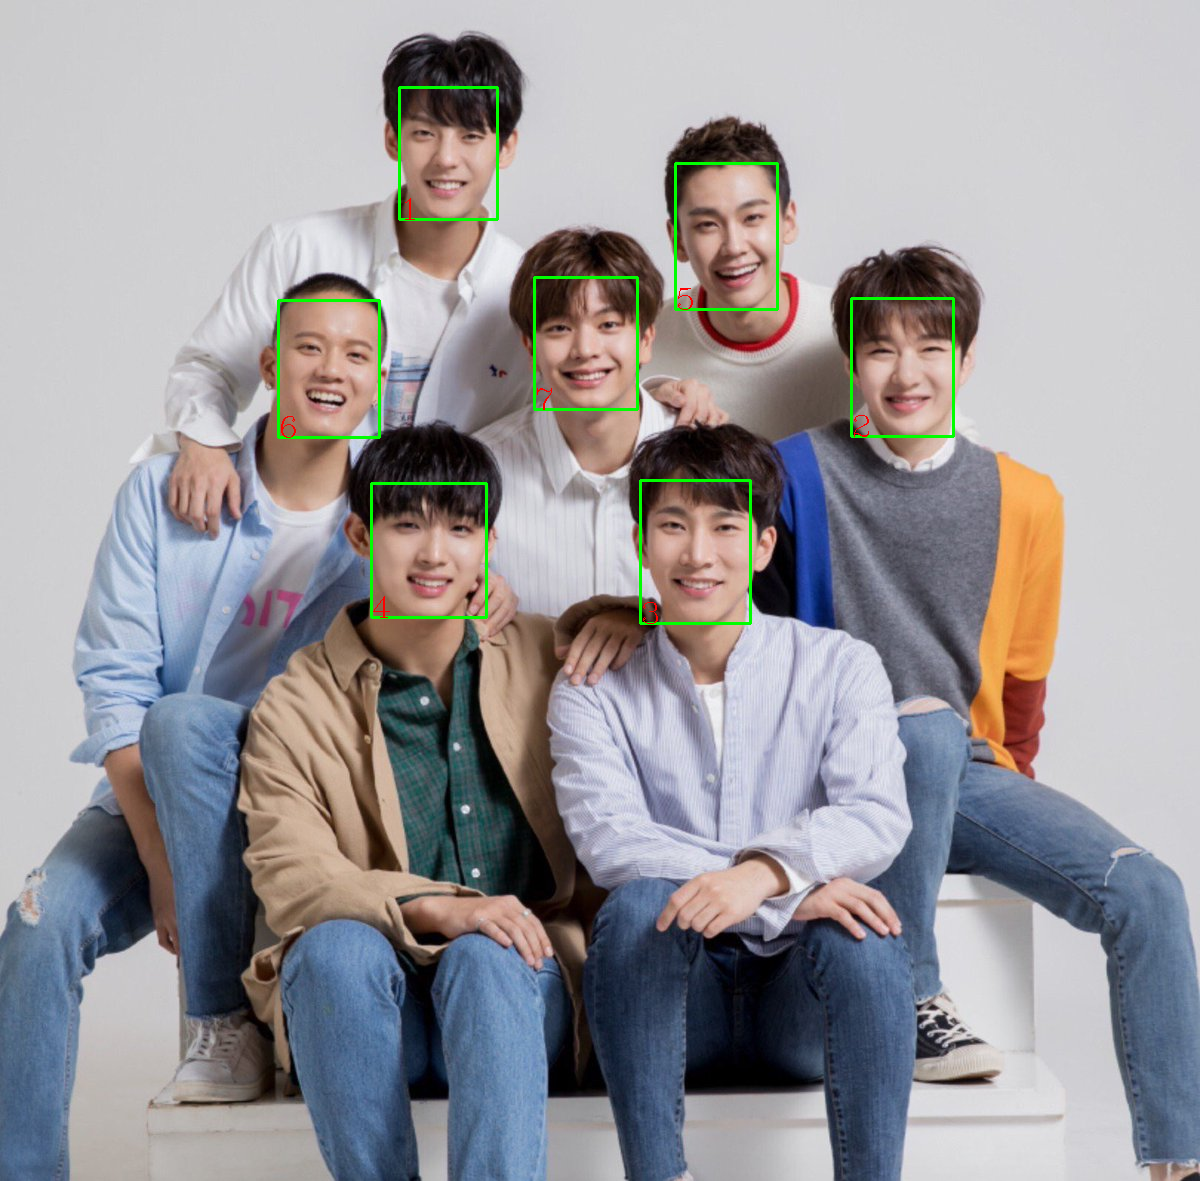

In [260]:
imshow(detection_list[0],input_image_list[0])

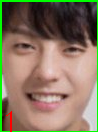

In [261]:
target_img = []
def select_img(select,input_image):
  target = input_image[boxes[select-1][1]:boxes[select-1][3],
                          boxes[select-1][0]:boxes[select-1][2]]
  target_img.append(target)
select_img(1,input_image_list[0])
cv2_imshow(target_img[0])

In [262]:
#################################

In [263]:
boxes_test = list(boxes[0])
print(boxes_test)

[399, 87, 497, 219]


In [264]:
boxes_test[0] = boxes_test[0] -40
boxes_test[1] = boxes_test[1] -40
boxes_test[2] = boxes_test[2]+40
boxes_test[3] = boxes_test[3]+40

# boxes_test[0] = boxes_test[0] 
# boxes_test[1] = boxes_test[1] 
# boxes_test[2] = boxes_test[2]
# boxes_test[3] = boxes_test[3]


In [265]:
boxes_result = input_image_list[0][boxes_test[1]:boxes_test[3],
                          boxes_test[0]:boxes_test[2]]
# boxes_result = input_image_list[0][boxes[0][1]:boxes[0][3],
#                           boxes[0][0]:boxes[0][2]]




In [266]:
iy = boxes_test[1] 
iy2 = boxes_test[3] 
ix = boxes_test[0] 
ix2 = boxes_test[2] 

In [267]:
if(ix2 < ix):
    ix2, ix = ix, ix2
if(iy2 < iy):
    iy2, iy = iy, iy2

width = abs(ix2-ix)
height = abs(iy2-iy)
xStart = ix
yStart = iy

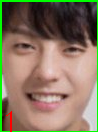

In [268]:
cv2_imshow(target_img[0])

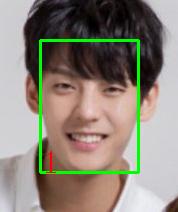

In [269]:
cv2_imshow(boxes_result)

In [270]:
boxes_result.shape

(212, 178, 3)

In [271]:
rect = patches.Rectangle((ix ,iy),width ,height , edgecolor='none', facecolor="none")


In [272]:
print(rect)

Rectangle(xy=(359, 47), width=178, height=212, angle=0)


In [273]:
rect = (xStart,yStart,width,height)

In [274]:
print(rect)

(359, 47, 178, 212)


In [275]:
boxes_test

[359, 47, 537, 259]

In [276]:
img.shape

(1181, 1200, 3)

In [277]:
img=np.uint8(img)
mask = np.uint8(mask)

In [278]:
img.shape

(1181, 1200, 3)

In [279]:
cv2.grabCut(img,mask,rect,None,None,5,cv2.GC_INIT_WITH_RECT)


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[ 9.08859441e-02,  3.57585794e-01,  2.50296214e-01,
          1.08265006e-01,  1.92967042e-01,  8.11720500e+01,
          7.37127187e+01,  8.31930018e+01,  2.11600352e+02,
          2.08885067e+02,  2.09103159e+02,  1.75085137e+02,
          1.77397293e+02,  1.92023726e+02,  3.55199404e+01,
          2.92975687e+01,  3.17632660e+01,  1.32311243e+02,
          1.14499043e+02,  1.08055362e+02,  8.59136917e+02,
          2.70754396e+02, -2.20383438e+02,  2.70754396e+02,
          3.05971195e+02,  2.55976381e+02, -2.20383438e+02,
          2.55976381e+02,  1.25312902e+03,  1.60544025e+01,
          1.39255096e+01,  1.37499557e+01,  1.39255096e+01,
          1.39570212e+01,  1.33456778e+01,  1.37499557e+01,
          1.33456778e+01,  1.30344051e+01,  1.53291387

In [280]:
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

In [281]:
rect

(359, 47, 178, 212)

In [282]:
fileName = '/content/Result_File'

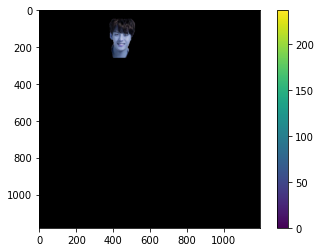

In [283]:
plt.imshow(img),plt.colorbar(),plt.show()
im = Image.fromarray(img)
im.save(fileName +'1.' + "PNG")

# Transfer black as transparent and save new image
img = Image.open(fileName +'1.' + "PNG")
img = img.convert("RGBA")
datas = img.getdata()
mask_1D = mask.flatten() 
index = 0
newData = []
for item in datas:
    if item[0] == 0 and item[1] == 0 and item[2] == 0 and mask_1D[index] == 0:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)
    index = index + 1

img.putdata(newData)
img.save(fileName +'2.'+ "PNG")

In [284]:
update_img = cv2.imread('/content/lecture_mosaic_project_data/dataset/bts.jpg')
img = img.astype(np.float32)

AttributeError: ignored

In [ ]:
###################

* target_img.png 파일을 load 해서 model이 요구하는 형태로 변환
  * shape : (1, 160, 160, 3)
  * dtype : float32
  * sacle : stanardization (across channels)
* faceNet model에 data 전달하여 예측 수행

In [ ]:
frame = cv2.imread('target_img.png')

In [ ]:
REQUIRED_SIZE = (160, 160)
frame = cv2.resize(frame, REQUIRED_SIZE).astype(np.float32)

In [ ]:
mean, std = frame.mean(), frame.std()

In [ ]:
frame = (frame-mean)/std

In [ ]:
y_pred = facenet_model(np.expand_dims(frame, axis=0))

In [ ]:
y_pred[0].numpy().shape

In [ ]:
mosaic_video='/content/lecture_mosaic_project_data/dataset/radio.mp4'
target_img = 'target_img.png'
save_videoname = 'radio_mosaic.mp4'

### 모자이크 서비스 구현
1. 동영상 파일을 load 한 프레임씩 이미지 정보 추출(30 frame) - matplotlib 이용하여 추출된 이미지 출력
2. retinaNet 모델을 이용하여 매 프레임 별로 출현하는 얼굴 정보 추출
3. faceNet 모델을 이용하여 매 프레임 별로 출현한 얼굴의 임베딩값 추출
4. 타겟 얼굴의 임베딩 값과 매 프레임 별로 추출된 임베딩 값들을 cosine 유사도를 계산하여 타겟 얼굴을 제외한 나머지 얼굴들에 대해서 모자이크  
> * 타겟 얼굴의 임베딩 값과 매 프레임 별로 추출된 임베딩 값들을 cosine 유사도를 계산
> * 유사도가 가장 높은 얼굴의 경우 threshold 값을 넘는지 체크
> * 유사도가 가장 높으면서 threshold 값을 넘는 얼굴은 원래 이미지 사용
> * 유사도가 가장 높지 않거나 threshold 값을 넘지 않는 얼굴은 모자이크 처리

In [ ]:
# 타겟 얼굴(조인성)의 임베딩값 계산
target_embedding = y_pred[0].numpy()

In [ ]:
i_frame = 0
cap = cv2.VideoCapture(mosaic_video)

width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
#재생할 파일의 높이 얻기
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
#재생할 파일의 프레임 레이트 얻기
fps = cap.get(cv2.CAP_PROP_FPS)

#저장할 비디오 코덱
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

#파일 stream 생성
out = cv2.VideoWriter(save_videoname, fourcc, fps, (int(width), int(height)))

while cap.isOpened():
  ret, frame = cap.read()

  if not ret or i_frame > 350:
    break
  
  orig = frame.copy()

  input_image = frame.astype(np.float32)
  img_height = input_image.shape[0]
  img_width = input_image.shape[1]

  face_detections = retina(np.expand_dims(input_image, axis=0)).numpy()

  embedding_box_dict = {}

  for i, face in enumerate(face_detections):
    x1, y1, x2, y2 = int(face[0] * img_width), int(face[1] * img_height), \
                    int(face[2] * img_width), int(face[3] * img_height)
    box = (abs(x1),abs(y1),abs(x2),abs(y2))
    
    face_tensor = orig[box[1]:box[3], box[0]:box[2]]
    face_img = face_tensor.copy()
    face_tensor = cv2.resize(face_tensor, REQUIRED_SIZE).astype(np.float32)

    mean, std = face_tensor.mean(), face_tensor.std()
    face_tensor = (face_tensor - mean) / std

    embedding = facenet_model(np.expand_dims(face_tensor, axis=0)).numpy()
    embedding_box_dict[i] = {'box' : box, 'embedding': embedding}

  distance_arraies=[]

  for i in range(0, len(embedding_box_dict)):
    distance = dot(embedding_box_dict[i]['embedding'], target_embedding)\
               /(norm(embedding_box_dict[i]['embedding']) * norm(target_embedding))
    distance_arraies.append(distance)

  most_simularity_index = np.array(distance_arraies).argmax()

  if distance_arraies[most_simularity_index] > 0.7:
    target_index = most_simularity_index
  else:
    target_index = None

  for index  in embedding_box_dict:
    if index != target_index:
      box = embedding_box_dict[index]['box']
      x1,y1, x2,y2 = box[0], box[1], box[2], box[3]
      orig[y1:y2, x1:x2] = cv2.blur(orig[y1:y2, x1:x2], (25,25))

  i_frame += 1

  # 인식된 이미지 파일로 저장
  out.write(orig)

  if i_frame % 50 == 0:
    print("{} frame".format(i_frame))

cap.release()
out.release()